<a href="https://colab.research.google.com/github/HugoFromont/Project/blob/master/Timeserie_forecasting/Notebook_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction sur des données timeseries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importation des données

In [ ]:
data = pd.read_csv('/content/drive/My Drive/data_google_colab/conso_enedis/data_forecast_timeseries.csv')
data.head()

,timestamp,total_soutiree,date_JF,is_vac,t
0,2018-01-01 00:00:00,1.245527e+10,1,1,11.743860
1,2018-01-01 00:30:00,1.242073e+10,1,1,11.594444
2,2018-01-01 01:00:00,1.234427e+10,1,1,11.445029
3,2018-01-01 01:30:00,1.227482e+10,1,1,11.295614
4,2018-01-01 02:00:00,1.227774e+10,1,1,11.146199


In [ ]:
train = data[data.timestamp<="2019-07-01"]
valid = data[data.timestamp>"2019-07-01"]

print("train : {} | {}%".format(train.shape, round(train.shape[0]/data.shape[0]*100)))
print("valid : {}  | {}%".format(valid.shape, round(valid.shape[0]/data.shape[0]*100)))

train : (26206, 5) | 75%
valid : (8834, 5)  | 25%


In [ ]:
conso_mean = train.total_soutiree.mean()
conso_std = train.total_soutiree.std()

t_mean = train.t.mean()
t_std = train.t.std()

train['target'] = (train.total_soutiree - conso_mean)/conso_std
valid['target'] = (valid.total_soutiree - conso_mean)/conso_std

train['t'] = (train.t - t_mean)/t_std
valid['t'] = (valid.t - t_mean)/t_std

## Création des matrices

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


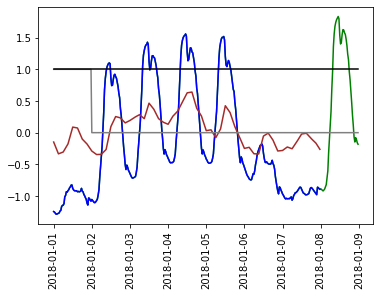

In [ ]:
date = [np.datetime64(time, 'm') for time in train.timestamp[:48*8]]
plt.plot(date,train.target[:48*8], color = "green")
plt.plot(date[:48*7],train.target[:48*7], color = "blue")
plt.plot(date[:48*7],train.t[:48*7]+0.5, color = "brown")
plt.plot(date[:48*8],train.date_JF[:48*8], color = "grey")
plt.plot(date[:48*8],train.is_vac[:48*8], color = "black")
plt.xticks(rotation=90)
plt.show()

In [ ]:
def create_matrice(data, length_vect = 150, nb_targets = 24):

  data = data.sort_values('timestamp')
  
  data_soutirage = np.array(data.target)
  data_date = np.array(data.timestamp)
  jf = np.array(data.date_JF)
  vac = np.array(data.is_vac)
  temperature = np.array(data.t)

  nb_ligne = data_soutirage.shape[0]

  matrice_features = []
  matrice_features_jf = []
  matrice_features_vac = []
  matrice_features_t = []
  matrice_features_date = []

  matrice_target = []
  matrice_target_jf = []
  matrice_target_vac = []
  matrice_target_date = []

  for i in range(0, nb_ligne-(length_vect+1 + nb_targets)):
    matrice_features.append(data_soutirage[i:i+length_vect])
    matrice_features_jf.append(jf[i:i+length_vect])
    matrice_features_vac.append(vac[i:i+length_vect])
    matrice_features_t.append(temperature[i:i+length_vect])
    matrice_features_date.append(data_date[i:i+length_vect])

    matrice_target.append(data_soutirage[i+length_vect+1:i+length_vect+1+nb_targets])
    matrice_target_jf.append(jf[i+length_vect+1:i+length_vect+1+nb_targets])
    matrice_target_vac.append(vac[i+length_vect+1:i+length_vect+1+nb_targets])
    matrice_target_date.append(data_date[i+length_vect+1:i+length_vect+1+nb_targets])

  return(np.array(matrice_features).reshape(-1,length_vect,1),
         np.array(matrice_features_jf).reshape(-1,length_vect,1),
         np.array(matrice_features_vac).reshape(-1,length_vect,1),
         np.array(matrice_features_t).reshape(-1,length_vect,1),
         np.array(matrice_features_date),
         np.array(matrice_target),
         np.array(matrice_target_jf).reshape(-1,nb_targets,1),
         np.array(matrice_target_vac).reshape(-1,nb_targets,1),
         np.array(matrice_target_date)
         )

In [ ]:
train_features,train_features_jf,train_features_vac,train_features_t,train_features_date,train_target,train_target_jf,train_target_vac,train_target_date = create_matrice(train, length_vect = 48*7, nb_targets = 48)
valid_features,valid_features_jf,valid_features_vac,valid_features_t,valid_features_date,valid_target,valid_target_jf,valid_target_vac,valid_target_date = create_matrice(valid, length_vect = 48*7, nb_targets = 48)

train_past_fetures = np.concatenate([train_features,train_features_jf],2)
valid_past_fetures = np.concatenate([valid_features,valid_features_jf],2)

## Création du modèle

In [ ]:
import tensorflow as tf

inputs_past_features = tf.keras.Input(shape=(48*7, 2))
inputs_future_features = tf.keras.Input(shape=(48, 1))

x = tf.keras.layers.LSTM(48)(inputs_past_features)
x = tf.keras.layers.Reshape((48,1))(x)

x = tf.concat([x, inputs_future_features], 2)
x = tf.keras.layers.LSTM(50, return_sequences = True)(x)
x = tf.keras.layers.LSTM(48)(x)
x = tf.keras.layers.Dense(48)(x)

model = tf.keras.Model([inputs_past_features, inputs_future_features], x)
model.summary()

optimizer = tf.keras.optimizers.Adam()

model.compile(loss='mse', optimizer=optimizer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 336, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 48)           9792        input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 48, 1)        0           lstm[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 1)]      0                                            
_____________

In [ ]:
model.fit([train_past_fetures,train_target_jf],
          train_target, 
          epochs = 300, 
          batch_size=172, 
          validation_data=([valid_past_fetures,valid_target_jf],valid_target), 
          shuffle=True)

## Visualisation

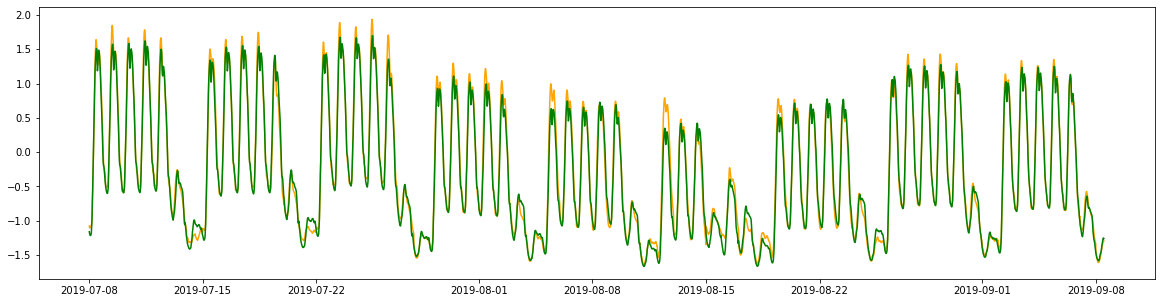

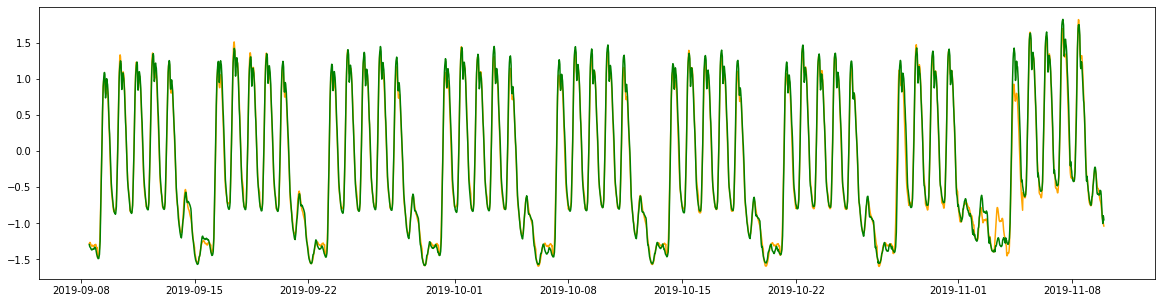

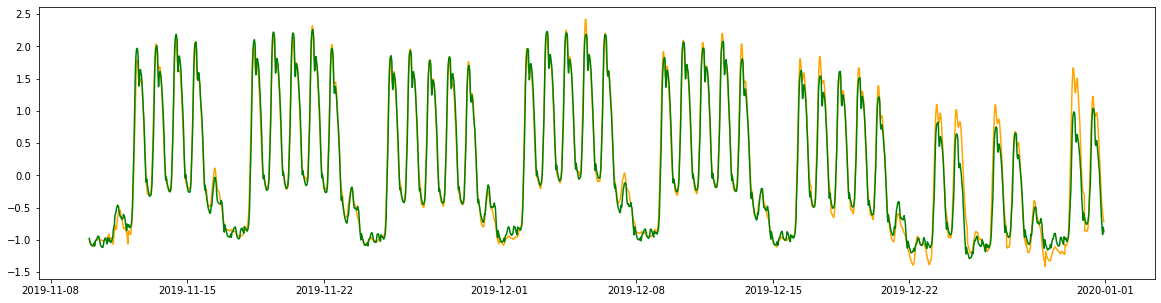

In [ ]:
all_pred = []
all_target = []
all_date = []
for i in range(0,len(pred),48):
  all_pred.append(pred[i])
  all_target.append(valid_target[i])
  all_date.append(valid_target_date[i])

all_date = np.array(all_date).reshape(-1)
date = [np.datetime64(time, 'm') for time in all_date]


fig = plt.figure(figsize=(20,5))
plt.plot(date[:3000],np.array(all_pred).reshape(-1)[:3000], color = "orange")
plt.plot(date[:3000],np.array(all_target).reshape(-1)[:3000], color = "green")
plt.show()

fig = plt.figure(figsize=(20,5))
plt.plot(date[3000:6000],np.array(all_pred).reshape(-1)[3000:6000], color = "orange")
plt.plot(date[3000:6000],np.array(all_target).reshape(-1)[3000:6000], color = "green")
plt.show()

fig = plt.figure(figsize=(20,5))
plt.plot(date[6000:9000],np.array(all_pred).reshape(-1)[6000:9000], color = "orange")
plt.plot(date[6000:9000],np.array(all_target).reshape(-1)[6000:9000], color = "green")
plt.show()



On peut voir que notre modèle est globalement correct. On peut quand même observer une sur-éstimation des pics de consos sur le mois d'aout et pendant les vacances de noël. 
On peut aussi voir que même si le modèle est moins précis sur les périodes de vacances et de jours feriée, il arrive quand même à prévoir le changement.